# Построение модели ARIMA для RTSI

В этой программе рассмотрим построение модели ARIMA для RTSI. Известны данные по индексу RTSI за 2017-2018 года, необходимо построить прогноз на следующее полугодие 2019 года.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


Введем даты, акции, входящие в индекс

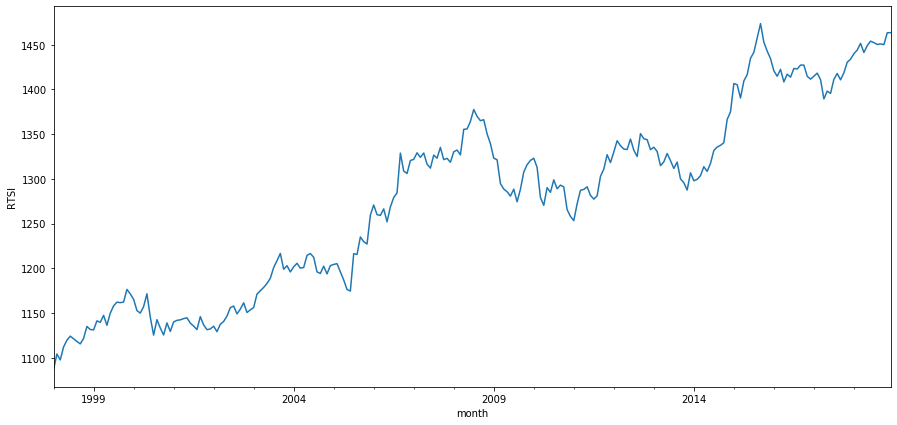

In [2]:
df = pd.read_csv('C:/Users/user/Desktop/ARIMA(RTSI)/VASYA2.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
df.id.plot()
plt.ylabel('RTSI')
pylab.show()

Здесь определим Критерий Дики-Фуллера, проверку стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.783091


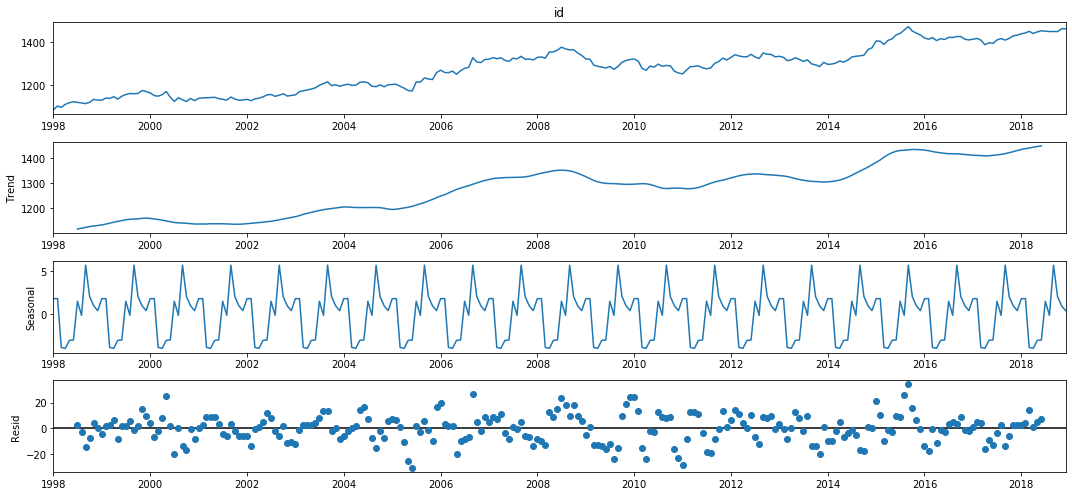

In [3]:
sm.tsa.seasonal_decompose(df.id,period=12).plot()
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.id)[1])

# Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии. Получим оптимальный параметр преобразования Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 0.697942
Критерий Дики-Фуллера: p=0.762623


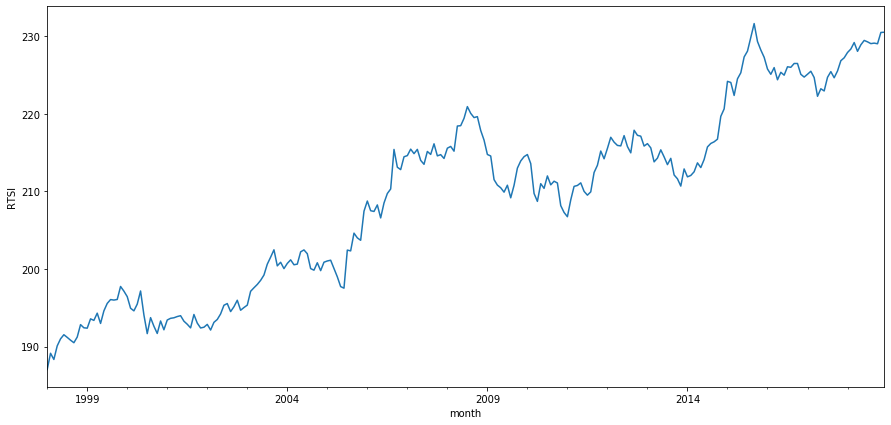

In [4]:
df['sales_box'], lmbda = stats.boxcox(pd.to_numeric(df.id))
plt.figure(figsize(15,7))
df.sales_box.plot()
plt.ylabel(u'RTSI')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box)[1])

# Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.020108


<Figure size 1080x720 with 0 Axes>

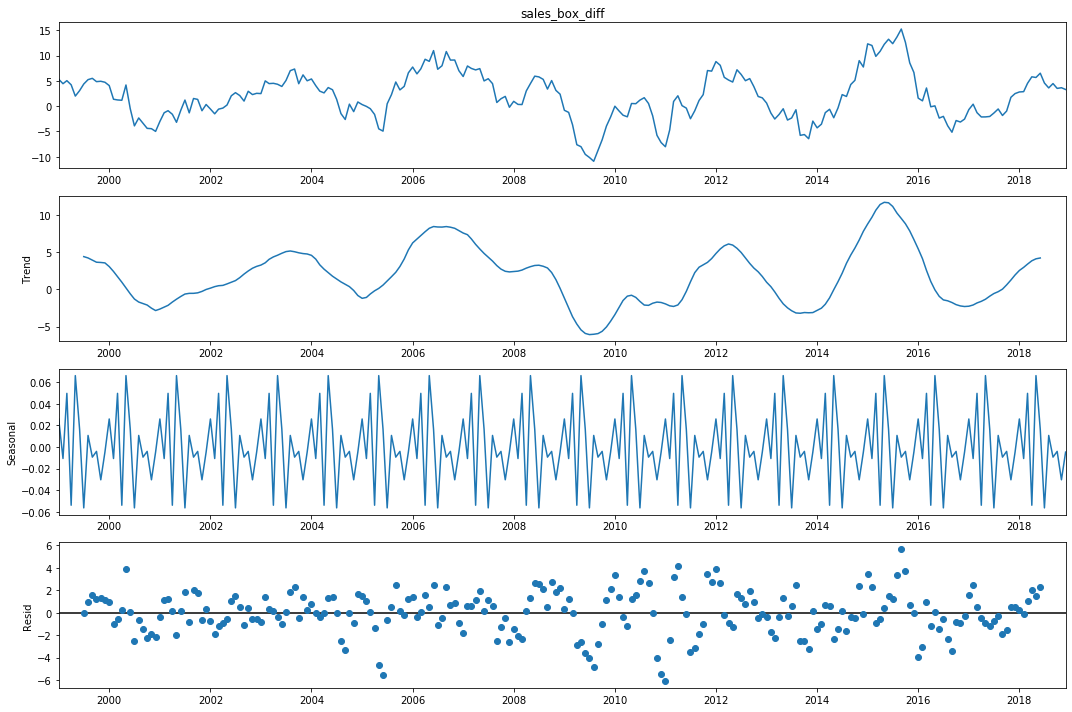

In [5]:
df['sales_box_diff'] = df.sales_box - df.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.sales_box_diff[12:],period=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

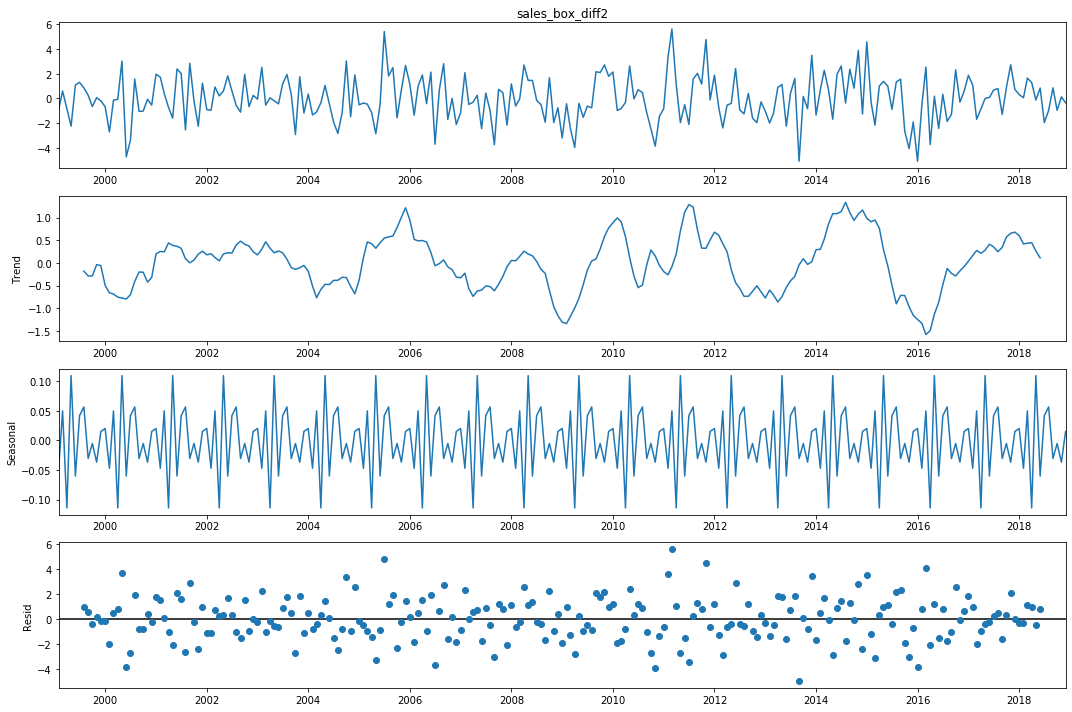

In [6]:
df['sales_box_diff2'] = df.sales_box_diff - df.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.sales_box_diff2[13:],period=12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

# Подбор модели

Посмотрим на ACF и PACF полученного ряда:

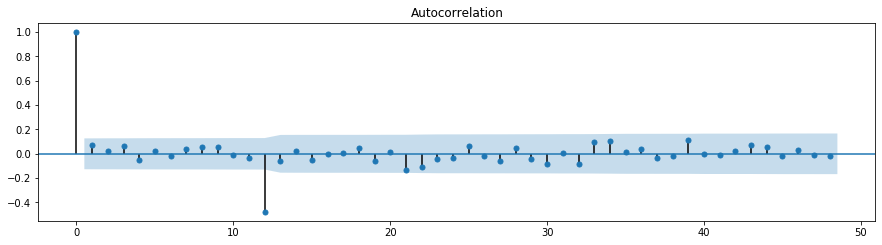

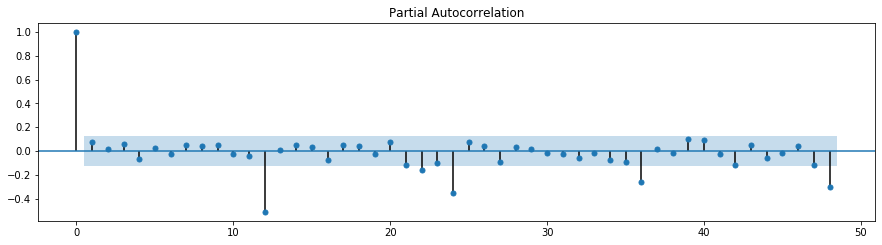

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [8]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [9]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

Выводим параметры, на которых модель не обучается и переходим к следующему набору:

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1min 42s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1

In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
1   (0, 0, 0, 1)  838.229054
29  (2, 1, 0, 1)  839.338219
21  (1, 2, 0, 1)  839.357915
3   (0, 0, 1, 1)  840.127220
13  (1, 0, 0, 1)  840.225357


Получим лучшую модель:

In [12]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            sales_box   No. Observations:                  252
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -417.115
Date:                              Sun, 06 Dec 2020   AIC                            838.229
Time:                                      23:25:04   BIC                            845.182
Sample:                                  01-01-1998   HQIC                           841.031
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9975      2.105     -0.474      0.636      -5.122       3.127
sigma2         1.65

Её остатки:

Критерий Стьюдента: p=0.641170
Критерий Дики-Фуллера: p=0.000000


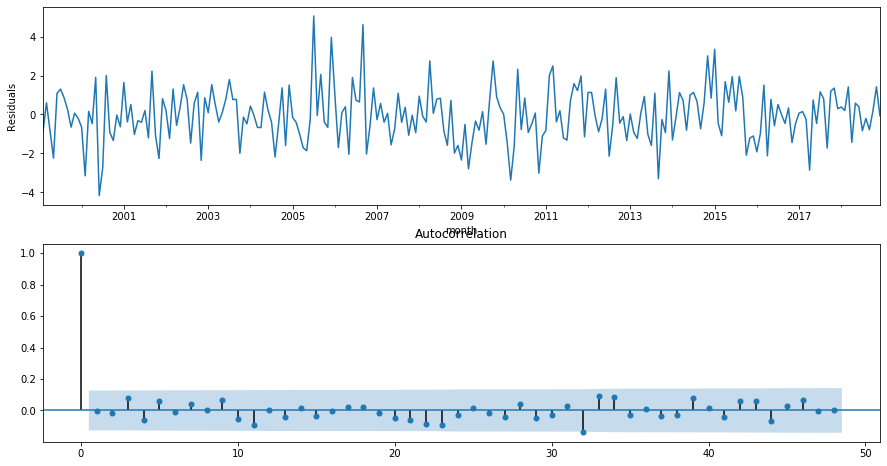

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

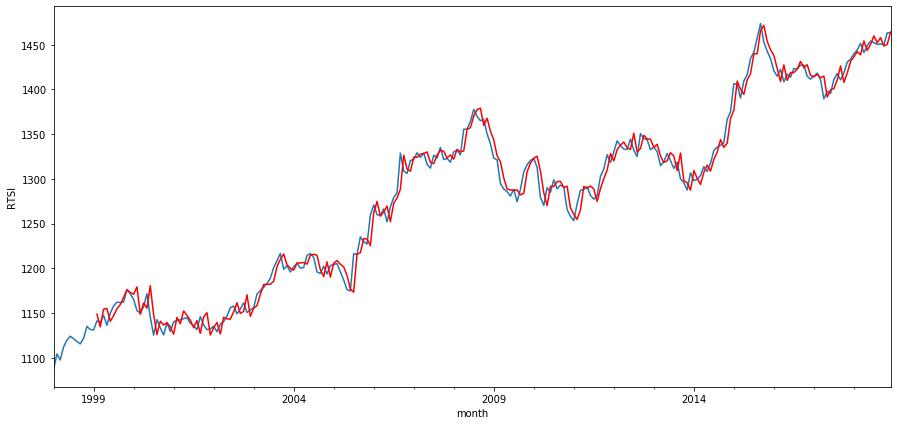

In [14]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.id.plot()
df.model[13:].plot(color='r')
plt.ylabel('RTSI')
pylab.show()

# Прогноз

Построим прогноз

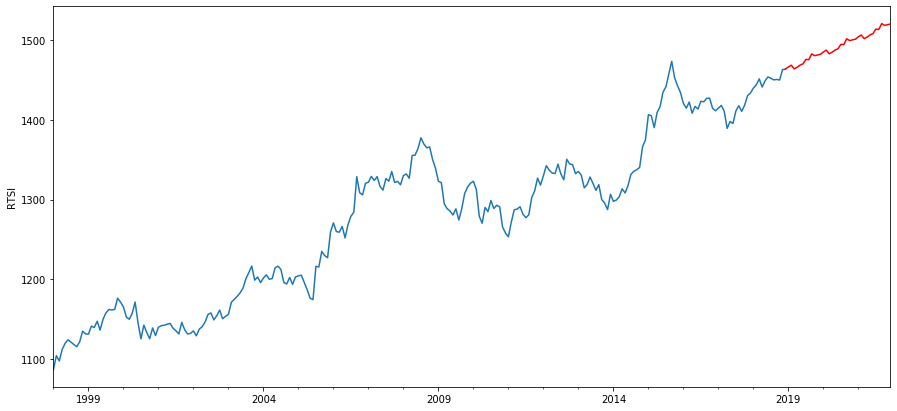

In [15]:
df2= df[['id']]
date_list = [datetime.datetime.strptime("2019-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=251, end=500), lmbda)

plt.figure(figsize(15,7))
df2.id.plot()
df2.forecast.plot(color='r')
plt.ylabel('RTSI')
pylab.show()